# Задание 2. Предобработка/Подготовка исходных данных.


Используется предложенный датасет №1 (DataSet3_1).

### Описание каждого значения в наборе данных.


| Столбец | Описание | Тип данных |
|-----------|-----------|-----------|
| Timestamp  | Дата и время записи данных  | Datetime |
| OAT (F)  | Температура воздуха в Фаренгейтах  | Integer  |
| Power (kW)  | Потребляемая/производимая мощность в киловаттах | Float  |

## Написание кода
### Для начала импортируем все нужные библиотеки и загрузим датасет.

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import lagrange, CubicSpline
from scipy import stats

df = pd.read_csv('/content/DataSet3_1.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34940 entries, 0 to 34939
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Timestamp   34940 non-null  object 
 1   OAT (F)     34940 non-null  int64  
 2   Power (kW)  34940 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 819.0+ KB


,Timestamp,OAT (F),Power (kW)
0,1/1/2010 1:15,51,165.1
1,1/1/2010 1:30,51,151.6
2,1/1/2010 1:45,51,146.9
3,1/1/2010 2:00,51,153.7
4,1/1/2010 2:15,51,153.8


## Подготовка данных

### Сначала преобразуем столбец "Timestamp", так как на данный момент он находится в формате object, а нам необходим формат datetime.

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

### Копирование значений для дальнейшей работы.

In [ ]:
# Копируем только необходимую строку в оригинальный датасет
df_original = df[['Power (kW)']].loc[:40].copy()

# Создаём копию для дальнейших манипуляций
df_sparse = df_original.copy()

# Прореживание значений(каждое второе)
df_sparse.loc[df_sparse.index % 2 == 1, 'Power (kW)'] =np.nan

# Создаем копию прореженного датафрейма для заполнения
df_filled = df_sparse.copy()

#### Заполнение средним

In [ ]:
mean_val = df_filled['Power (kW)'].mean()
df_filled['Power (kW)_filled_mean'] = df_filled['Power (kW)'].fillna(mean_val)
print(f"✅ {'Power (kW)'} — заполнено средним: {mean_val:.3f}")

print("\nПример заполнения средним:")
df_filled.head()

✅ Power (kW) — заполнено средним: 194.871

Пример заполнения средним:


,Power (kW),Power (kW)_filled_mean
0,165.1,165.100000
1,NaN,194.871429
2,146.9,146.900000
3,NaN,194.871429
4,153.8,153.800000


#### Заполнение медианным значением

In [ ]:
median_val = df_filled['Power (kW)'].median()
df_filled['Power (kW)_filled_median'] = df_filled['Power (kW)'].fillna(median_val)
print(f"✅ {'Power (kW)'} — заполнено медианным значением: {median_val:.3f}")

print("\nПример заполнения медианным:")
df_filled[['Power (kW)', 'Power (kW)_filled_median']].head()

✅ Power (kW) — заполнено медианным значением: 165.100

Пример заполнения медианным:


,Power (kW),Power (kW)_filled_median
0,165.1,165.1
1,NaN,165.1
2,146.9,146.9
3,NaN,165.1
4,153.8,153.8


#### Заполнение средним трёх предыдущих значений

In [ ]:
# Функция для подсчёта
def fill_with_prev_mean(series, window=3):
    filled = series.copy()
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):
            # Берем предыдущие НЕ NaN значения в пределах окна
            start_idx = max(0, i - window)
            prev_vals = series.iloc[start_idx:i]
            filled.iloc[i] = prev_vals.mean()
    return filled

df_filled['Power (kW)_filled_prev3mean'] = fill_with_prev_mean(df_filled['Power (kW)'])

print("\nПример заполнения средним трёх предыдущих значений:")
df_filled[['Power (kW)', 'Power (kW)_filled_prev3mean']].head()


Пример заполнения средним трёх предыдущих значений:


,Power (kW),Power (kW)_filled_prev3mean
0,165.1,165.1
1,NaN,165.1
2,146.9,146.9
3,NaN,156.0
4,153.8,153.8


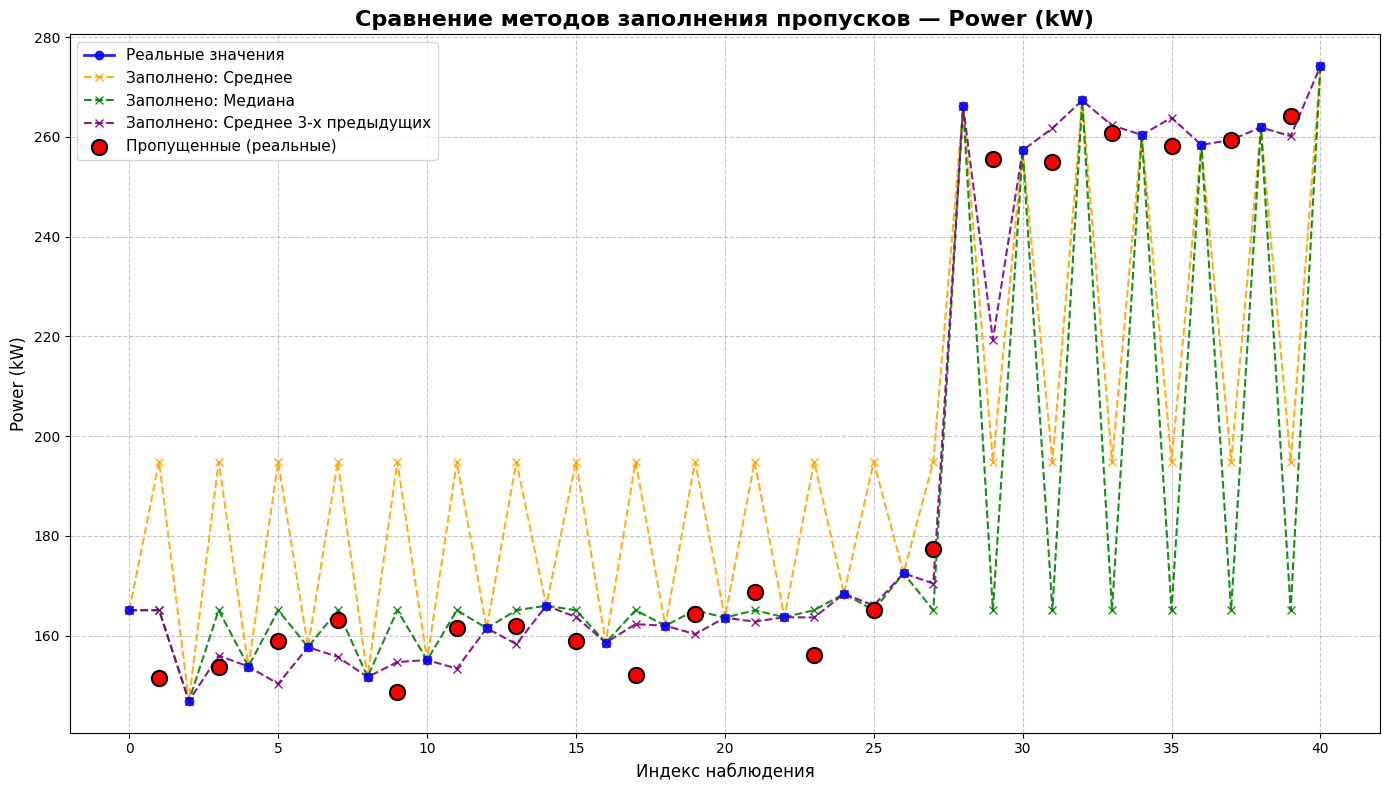

In [ ]:
methods_cols = [f'Power (kW)_filled_{m}' for m in ['mean', 'median', 'prev3mean']]
method_names = ['Среднее', 'Медиана', 'Среднее 3-х предыдущих']
colors = ['orange', 'green', 'purple']

plt.figure(figsize=(14, 8))

# Реальные значения — синяя сплошная линия
plt.plot(df_filled.index, df_filled['Power (kW)'], 'o-', label='Реальные значения', color='blue', linewidth=2, alpha=0.85, zorder=10)

# Каждый метод — отдельной линией
for filled_col, name, color in zip(methods_cols, method_names, colors):
    plt.plot(df_filled.index, df_filled[filled_col], 'x--', label=f'Заполнено: {name}',
             color=color, linewidth=1.5, alpha=0.9, markersize=6)

# Пропущенные реальные значения из оригинала
missing_mask = df_sparse['Power (kW)'].isna()
real_missing_values = df_original.loc[missing_mask, 'Power (kW)']

plt.scatter(df_filled.index[missing_mask],
            real_missing_values,
            color='red', label='Пропущенные (реальные)',
            zorder=20, s=120, edgecolor='black', linewidth=1.5)

plt.title(f'Сравнение методов заполнения пропусков — Power (kW)', fontsize=16, fontweight='bold')
plt.xlabel('Индекс наблюдения', fontsize=12)
plt.ylabel('Power (kW)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Интерполяционная формула Лагранжа

In [ ]:
known_idx = df_filled[df_filled['Power (kW)'].notna()].index
known_vals = df_filled.loc[known_idx, 'Power (kW)'].values

# Строим полином Лагранжа
poly = lagrange(known_idx, known_vals)
lagrange_vals = poly(df_filled.index)

df_filled['Power (kW)_filled_lagrange'] = lagrange_vals
print(f"✅ Power (kW) — заполнено методом Лагранжа")

print("\nПример заполнения Лагранжем:")
df_filled[['Power (kW)', 'Power (kW)_filled_prev3mean']].head(8)

✅ Power (kW) — заполнено методом Лагранжа

Пример заполнения Лагранжем:


,Power (kW),Power (kW)_filled_prev3mean
0,165.1,165.10
1,NaN,165.10
2,146.9,146.90
3,NaN,156.00
4,153.8,153.80
5,NaN,150.35
6,157.7,157.70
7,NaN,155.75


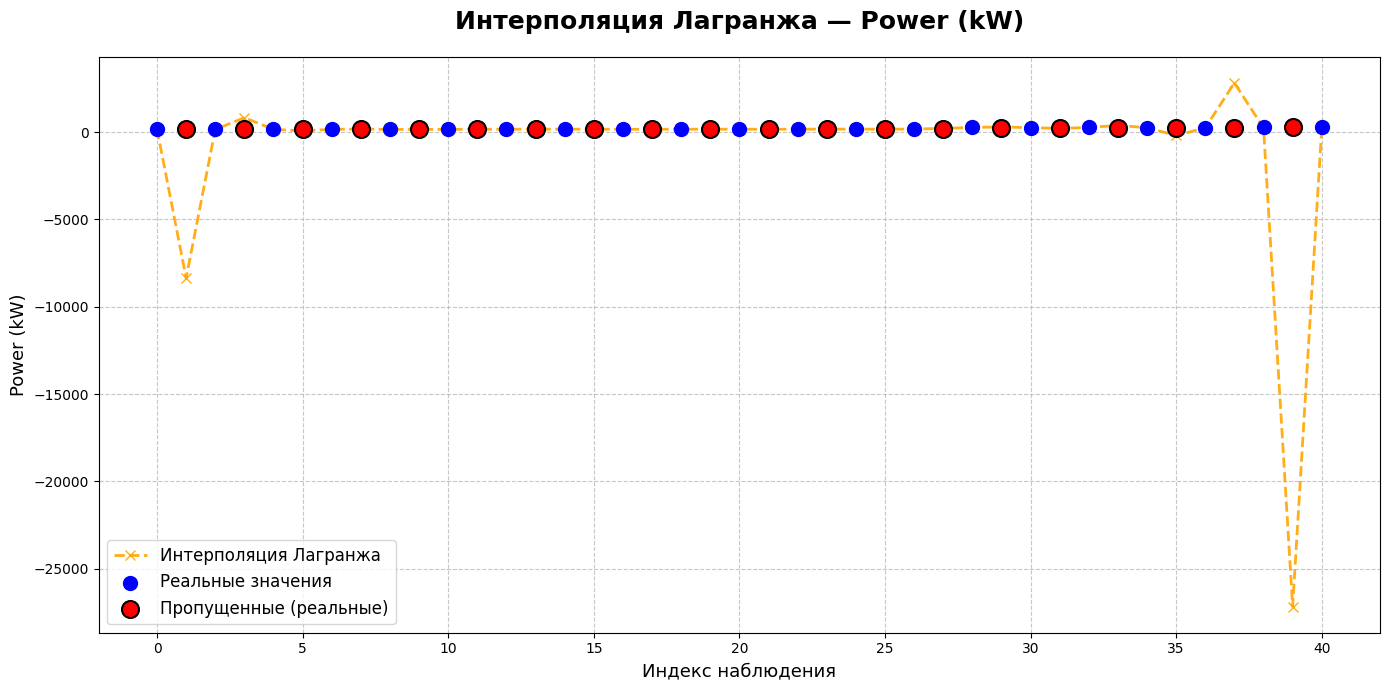

In [ ]:
# Визуализируем результат лагранжа

col = 'Power (kW)'
filled_col = f'{col}_filled_lagrange'

plt.figure(figsize=(14, 7))

# Заполненные Лагранжем
plt.plot(df_filled.index, df_filled[filled_col], 'x--',
         label='Интерполяция Лагранжа', color='orange', linewidth=2, alpha=0.9, markersize=7)

# Реальные значения (оригинал)
plt.scatter(df_filled.index, df_original[col],
         label='Реальные значения', color='blue', zorder=10, s=100,)

# Пропущенные реальные точки
missing_mask = df_sparse[col].isna()
real_missing_values = df_original.loc[missing_mask, col]

plt.scatter(df_filled.index[missing_mask],
            real_missing_values,
            color='red', label='Пропущенные (реальные)',
            zorder=20, s=150, edgecolor='black', linewidth=1.5)

plt.title(f'Интерполяция Лагранжа — {col}', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Индекс наблюдения', fontsize=13)
plt.ylabel(col, fontsize=13)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Кубический Сплайн

In [ ]:
known_idx = df_filled[df_filled['Power (kW)'].notna()].index
known_vals = df_filled.loc[known_idx, 'Power (kW)'].values

# Создаем кубический сплайн
cs = CubicSpline(known_idx, known_vals, bc_type='natural')
spline_vals = cs(df_filled.index)

df_filled['Power (kW)_filled_spline'] = spline_vals

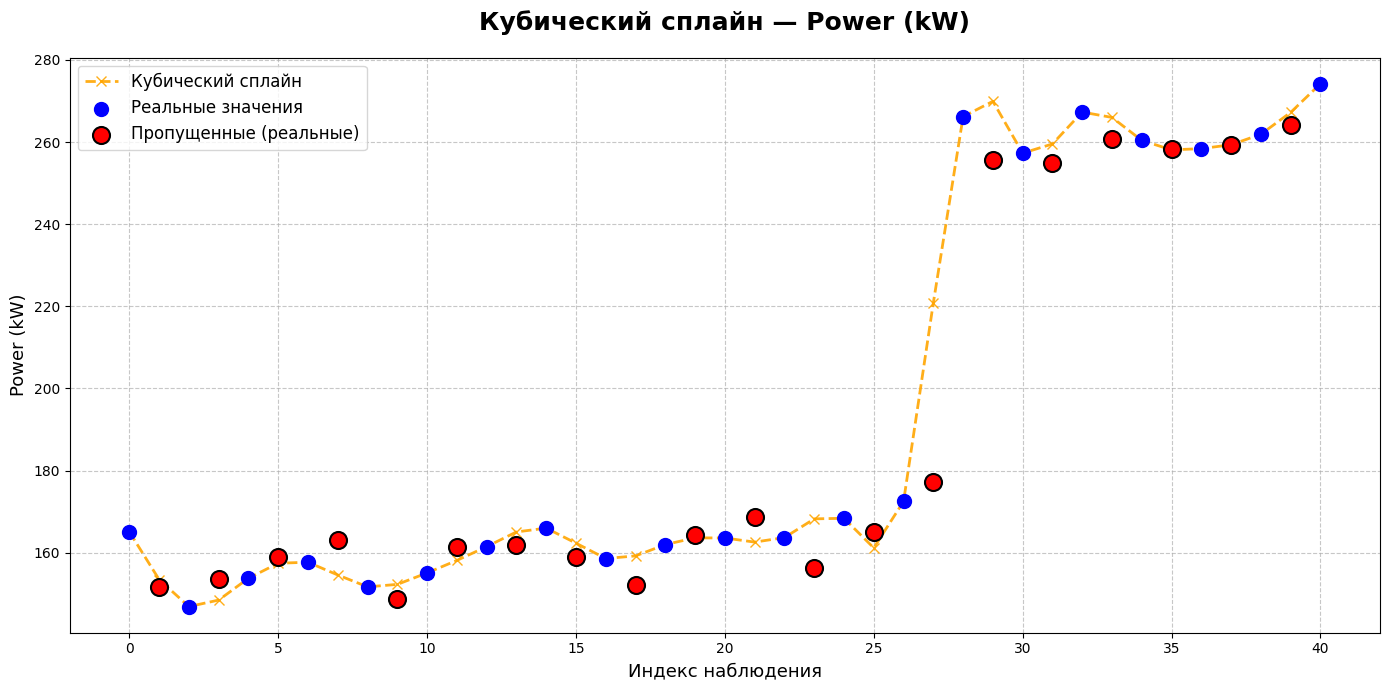

In [ ]:
# Визуализируем результат кубического сплайна

col = 'Power (kW)'
filled_col = f'{col}_filled_spline'

plt.figure(figsize=(14, 7))

# Заполненные кубическим сплайном
plt.plot(df_filled.index, df_filled[filled_col], 'x--',
         label='Кубический сплайн', color='orange', linewidth=2, alpha=0.9, markersize=7)

# Реальные значения (оригинал)
plt.scatter(df_filled.index, df_original[col],
         label='Реальные значения', color='blue', zorder=10, s=100,)

# Пропущенные реальные точки
missing_mask = df_sparse[col].isna()
real_missing_values = df_original.loc[missing_mask, col]

plt.scatter(df_filled.index[missing_mask],
            real_missing_values,
            color='red', label='Пропущенные (реальные)',
            zorder=20, s=150, edgecolor='black', linewidth=1.5)

plt.title(f'Кубический сплайн — {col}', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Индекс наблюдения', fontsize=13)
plt.ylabel(col, fontsize=13)
plt.legend(loc='best', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Визуализация всех графиков

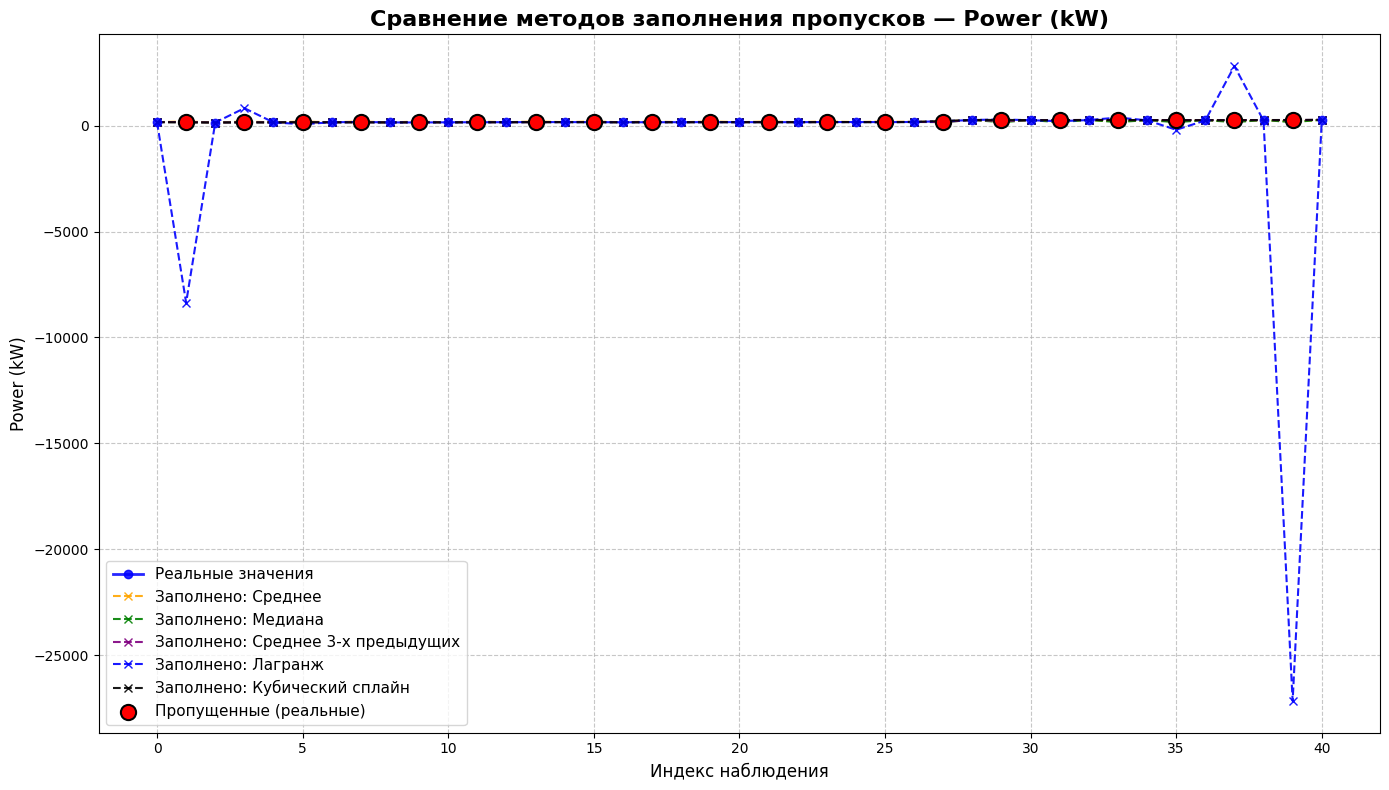

In [ ]:
# Визуализация общего результата

col = 'Power (kW)'
methods_cols = [f'{col}_filled_{m}' for m in ['mean', 'median', 'prev3mean', 'lagrange', 'spline']]
method_names = ['Среднее', 'Медиана', 'Среднее 3-х предыдущих', 'Лагранж', 'Кубический сплайн']
colors = ['orange', 'green', 'purple',  'blue', 'black']

plt.figure(figsize=(14, 8))

# Реальные значения — синяя сплошная линия
plt.plot(df_filled.index, df_filled[col], 'o-', label='Реальные значения', color='blue', linewidth=2, alpha=0.85, zorder=10)

# Каждый метод — отдельной линией
for filled_col, name, color in zip(methods_cols, method_names, colors):
    plt.plot(df_filled.index, df_filled[filled_col], 'x--', label=f'Заполнено: {name}',
             color=color, linewidth=1.5, alpha=0.9, markersize=6)

# Пропущенные реальные значения из оригинала
missing_mask = df_sparse[col].isna()
real_missing_values = df_original.loc[missing_mask, col]

plt.scatter(df_filled.index[missing_mask],
            real_missing_values,
            color='red', label='Пропущенные (реальные)',
            zorder=20, s=120, edgecolor='black', linewidth=1.5)

plt.title(f'Сравнение методов заполнения пропусков — {col}', fontsize=16, fontweight='bold')
plt.xlabel('Индекс наблюдения', fontsize=12)
plt.ylabel(col, fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Визуализация графиков без Лагранжа

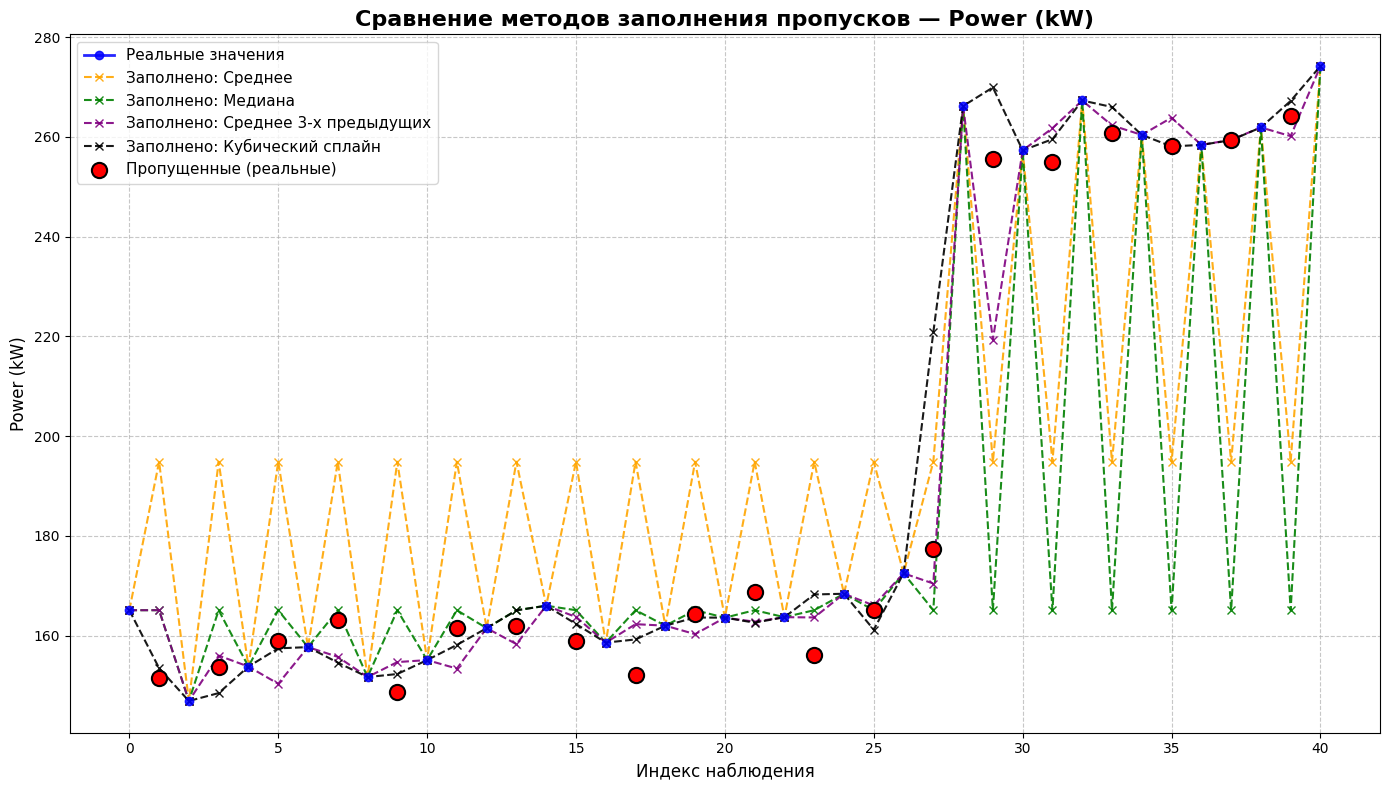

In [ ]:
# Визуализация общего результата

col = 'Power (kW)'
methods_cols = [f'{col}_filled_{m}' for m in ['mean', 'median', 'prev3mean', 'spline']]
method_names = ['Среднее', 'Медиана', 'Среднее 3-х предыдущих', 'Кубический сплайн']
colors = ['orange', 'green', 'purple', 'black']

plt.figure(figsize=(14, 8))

# Реальные значения — синяя сплошная линия
plt.plot(df_filled.index, df_filled[col], 'o-', label='Реальные значения', color='blue', linewidth=2, alpha=0.85, zorder=10)

# Каждый метод — отдельной линией
for filled_col, name, color in zip(methods_cols, method_names, colors):
    plt.plot(df_filled.index, df_filled[filled_col], 'x--', label=f'Заполнено: {name}',
             color=color, linewidth=1.5, alpha=0.9, markersize=6)

# Пропущенные реальные значения из оригинала
missing_mask = df_sparse[col].isna()
real_missing_values = df_original.loc[missing_mask, col]

plt.scatter(df_filled.index[missing_mask],
            real_missing_values,
            color='red', label='Пропущенные (реальные)',
            zorder=20, s=120, edgecolor='black', linewidth=1.5)

plt.title(f'Сравнение методов заполнения пропусков — {col}', fontsize=16, fontweight='bold')
plt.xlabel('Индекс наблюдения', fontsize=12)
plt.ylabel(col, fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Анализ выбросов
### 📊 Анализ выбросов методом 2σ и 3σ

In [ ]:
print(f"\n=== Анализ выбросов для {col} — метод 2/3 сигмы ===")

mean_val = df_original[col].mean()
std_val = df_original[col].std()

# 2 сигмы
lower_2s = mean_val - 2 * std_val
upper_2s = mean_val + 2 * std_val
outliers_2s = df_original[(df_original[col] < lower_2s) | (df_original[col] > upper_2s)]
print(f"Выбросы (2σ): {len(outliers_2s)} точек из {df_original[col].shape[0]}")

# 3 сигмы
lower_3s = mean_val - 3 * std_val
upper_3s = mean_val + 3 * std_val
outliers_3s = df_original[(df_original[col] < lower_3s) | (df_original[col] > upper_3s)]
print(f"Выбросы (3σ): {len(outliers_3s)} точек из {df_original[col].shape[0]}")



=== Анализ выбросов для Power (kW) — метод 2/3 сигмы ===
Выбросы (2σ): 0 точек из 41
Выбросы (3σ): 0 точек из 41


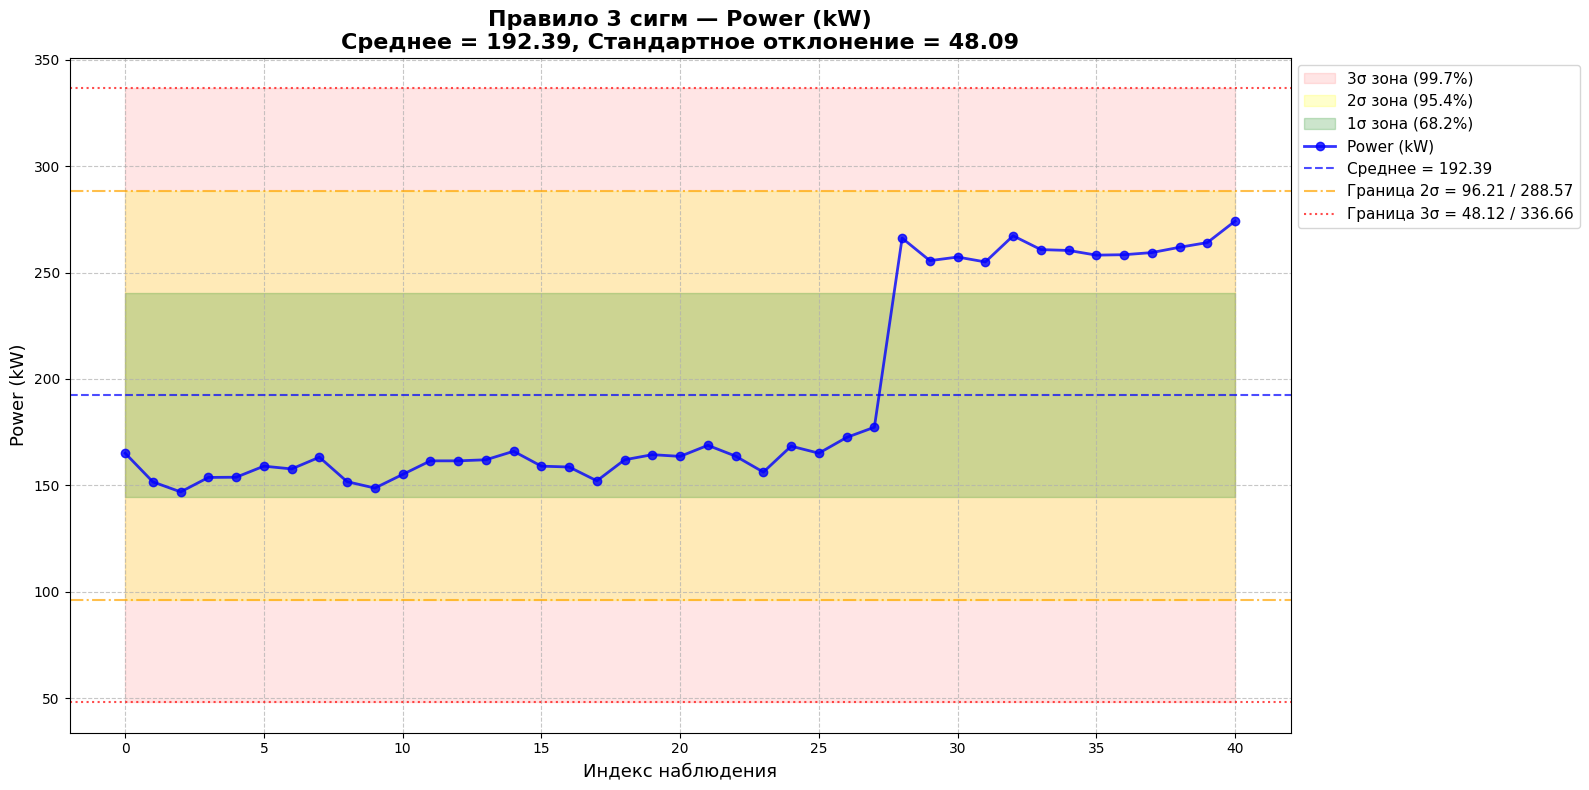


📊 Статистика выбросов для Power (kW):
Всего точек: 41
Выбросы за 2σ: 0 (0.0%)
Выбросы за 3σ: 0 (0.0%)


In [ ]:
# Считаем статистики по исходным данным (до прореживания!)
mean_val = df_original[col].mean()
std_val = df_original[col].std()

# Границы
lower_3s = mean_val - 3 * std_val
upper_3s = mean_val + 3 * std_val
lower_2s = mean_val - 2 * std_val
upper_2s = mean_val + 2 * std_val
lower_1s = mean_val - std_val
upper_1s = mean_val + std_val

# Определяем выбросы
outliers_2s = df_original[(df_original[col] < lower_2s) | (df_original[col] > upper_2s)]
outliers_3s = df_original[(df_original[col] < lower_3s) | (df_original[col] > upper_3s)]
outliers_2to3 = df_original[
    ((df_original[col] < lower_2s) & (df_original[col] >= lower_3s)) |
    ((df_original[col] > upper_2s) & (df_original[col] <= upper_3s))
]

plt.figure(figsize=(16, 8))

# Зоны (заливка)
plt.fill_between(df_original.index, lower_3s, upper_3s, color='red', alpha=0.1, label='3σ зона (99.7%)')
plt.fill_between(df_original.index, lower_2s, upper_2s, color='yellow', alpha=0.2, label='2σ зона (95.4%)')
plt.fill_between(df_original.index, lower_1s, upper_1s, color='green', alpha=0.2, label='1σ зона (68.2%)')

# Основной ряд
plt.plot(df_original.index, df_original[col], 'o-', color='blue', label=col, linewidth=2, alpha=0.8)

# Выбросы
if not outliers_3s.empty:
    plt.scatter(outliers_3s.index, outliers_3s[col],
                color='red', s=120, edgecolor='black', linewidth=1.5,
                label='Выбросы (>3σ)', zorder=5)

if not outliers_2to3.empty:
    plt.scatter(outliers_2to3.index, outliers_2to3[col],
                color='orange', s=100, edgecolor='black', linewidth=1,
                label='Аномалии (2σ–3σ)', zorder=5)

# Горизонтальные линии
plt.axhline(mean_val, color='blue', linestyle='--', label=f'Среднее = {mean_val:.2f}', alpha=0.7)
plt.axhline(lower_2s, color='orange', linestyle='-.', label=f'Граница 2σ = {lower_2s:.2f} / {upper_2s:.2f}', alpha=0.7)
plt.axhline(upper_2s, color='orange', linestyle='-.', alpha=0.7)
plt.axhline(lower_3s, color='red', linestyle=':', label=f'Граница 3σ = {lower_3s:.2f} / {upper_3s:.2f}', alpha=0.7)
plt.axhline(upper_3s, color='red', linestyle=':', alpha=0.7)

plt.title(f'Правило 3 сигм — {col}\nСреднее = {mean_val:.2f}, Стандартное отклонение = {std_val:.2f}',
          fontsize=16, fontweight='bold')
plt.xlabel('Индекс наблюдения', fontsize=13)
plt.ylabel(col, fontsize=13)
plt.legend(loc='upper left', fontsize=11, bbox_to_anchor=(1, 1))
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Выведем количество выбросов
print(f"\n📊 Статистика выбросов для {col}:")
print(f"Всего точек: {len(df_original)}")
print(f"Выбросы за 2σ: {len(outliers_2s)} ({len(outliers_2s)/len(df_original)*100:.1f}%)")
print(f"Выбросы за 3σ: {len(outliers_3s)} ({len(outliers_3s)/len(df_original)*100:.1f}%)")

### 📊 Анализ выбросов методом Boxplot

/tmp/ipython-input-948017804.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Метод', y='Value', palette='Set3', linewidth=1.5)


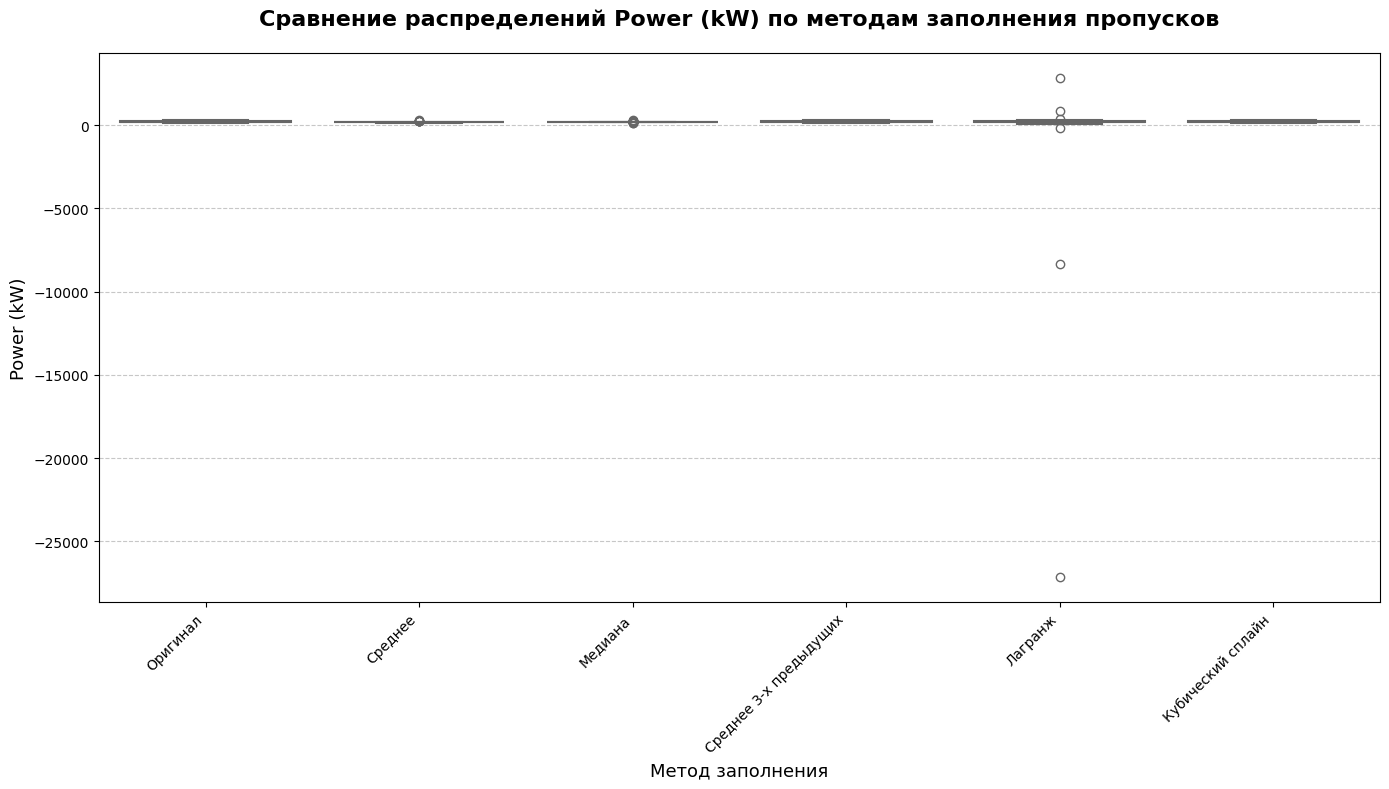

In [ ]:
# Оценим диаграммы размаха для одного из показателей
# Список столбцов для сравнения
columns_to_plot = [
    col,  # оригинал
    f'{col}_filled_mean',
    f'{col}_filled_median',
    f'{col}_filled_prev3mean',
    f'{col}_filled_lagrange',
    f'{col}_filled_spline',

]

# Переименуем для красивых подписей на графике
method_labels = [
    'Оригинал',
    'Среднее',
    'Медиана',
    'Среднее 3-х предыдущих',
    'Лагранж',
    'Кубический сплайн'
]

# Подготовим данные для seaborn: "длинный" формат
df_melted = df_filled[columns_to_plot].melt(var_name='Метод', value_name='Value')
df_melted['Метод'] = df_melted['Метод'].replace(dict(zip(columns_to_plot, method_labels)))

# Построение
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Метод', y='Value', palette='Set3', linewidth=1.5)

plt.title(f'Сравнение распределений {col} по методам заполнения пропусков', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Метод заполнения', fontsize=13)
plt.ylabel(col, fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Визуализация без Лагранжа

/tmp/ipython-input-3125000518.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x='Метод', y='Value', palette='Set3', linewidth=1.5)


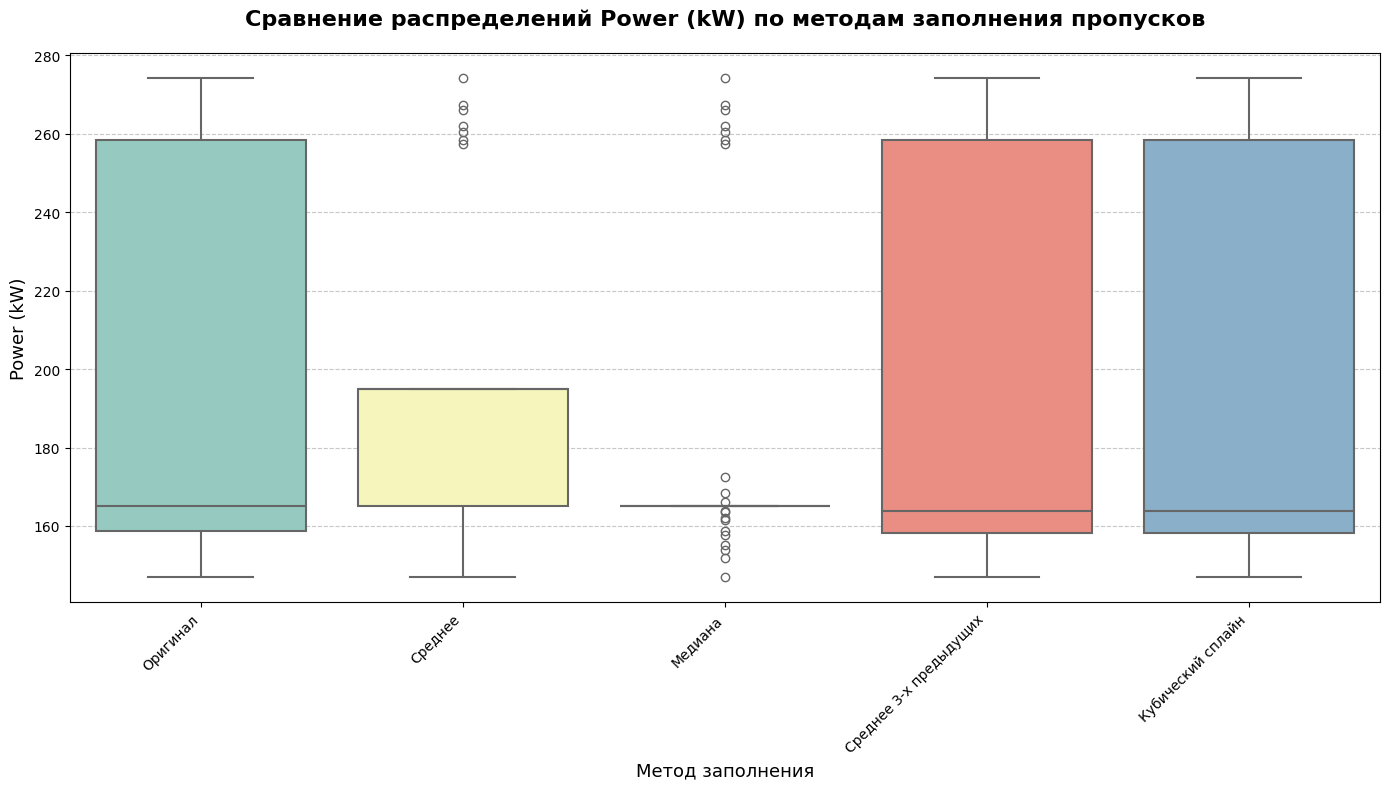

In [ ]:
# Список столбцов для сравнения
columns_to_plot = [
    col,  # оригинал
    f'{col}_filled_mean',
    f'{col}_filled_median',
    f'{col}_filled_prev3mean',
    f'{col}_filled_spline',

]

# Переименуем для красивых подписей на графике
method_labels = [
    'Оригинал',
    'Среднее',
    'Медиана',
    'Среднее 3-х предыдущих',
    'Кубический сплайн'
]

# Подготовим данные для seaborn: "длинный" формат
df_melted = df_filled[columns_to_plot].melt(var_name='Метод', value_name='Value')
df_melted['Метод'] = df_melted['Метод'].replace(dict(zip(columns_to_plot, method_labels)))

# Построение
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Метод', y='Value', palette='Set3', linewidth=1.5)

plt.title(f'Сравнение распределений {col} по методам заполнения пропусков', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Метод заполнения', fontsize=13)
plt.ylabel(col, fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()